In [ ]:
%pip freeze

In [ ]:
%pip install plotly 

In [ ]:
%pip install uszipcode

In [ ]:
%pip install geopandas

In [ ]:
%pip install lenspy

In [ ]:
import pandas as pd 
import numpy as np 
from datetime import date 
import plotly.graph_objects as go 
import plotly.express as px
from lenspy import DynamicPlot
import json
import geopandas as gpd
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lat_lon_to_zips import map_lat_lon_to_zips

# Random Forests by Zipcode

### bikes and weather

In [ ]:
%%bigquery df
SELECT 
    EXTRACT(DAYOFYEAR FROM bike.starttime) AS day_of_year,
    EXTRACT(YEAR FROM bike.starttime) AS year,
    bike.start_station_name AS start_station_name,
    SUM(bike.tripduration) AS total_duration,
    MAX(bike.start_station_latitude) AS lat,
    MAX(bike.start_station_longitude) AS lon,
    SUM(weather.prcp) AS sum_prcp,
    SUM(weather.tmin) AS sum_tmin,
    SUM(weather.tmax) AS sum_tmax,
    SUM(weather.snow) AS sum_snow,
    SUM(weather.wind) AS sum_wind
FROM `hackathon-team-05.team05bike.noaa_daily_weather_nyc_central_park` AS weather
INNER JOIN `hackathon-team-05.team05bike.NYCbike` AS bike
ON weather.date = EXTRACT(DATE FROM bike.starttime)
GROUP BY 1, 2, 3

In [ ]:
def summarize_df(df: pd.DataFrame):
    print('df.shape', df.shape)
    print('='*100)
    print('df.head()', df.head())
    print('='*100)
    print('df.describe()', df.describe())
    
def sort(df, sort_cols):
    return df.sort_values(sort_cols)

def define_mobility_index(df, col_to_index):
    df['mobility_index'] = 100 * df[col_to_index] / df[col_to_index].iloc[0]
    return df, 'mobility_index'

def add_pct_change_to_index(df, y, period):
    df[y + '_diff'] = df[y].pct_change(periods=period)
    return df
    
def add_momentum_terms(df, mobility_index, rolling_averages):
    for rolling_avg in rolling_averages:
        df['momentum_r' + str(rolling_avg)] = (
            df[mobility_index + '_diff'].rolling(rolling_avg).mean() * 1 + df[mobility_index]
        ).shift(1)
    return df

def add_timeshift_to_index(df, mobility_index, shifts_to_y):
    for shift in shifts_to_y:
        df[mobility_index + '_t' + str(abs(shift))] = df[mobility_index].shift(shift)
    return df

def setup_df(df, sort_cols, col_to_index, period, rolling_averages, shifts_to_y):
    df = sort(df, sort_cols)
    df, mobility_index = define_mobility_index(df, col_to_index)
    df = add_pct_change_to_index(df, mobility_index, period)
    df = add_momentum_terms(df, mobility_index, rolling_averages)
    df = add_timeshift_to_index(df, mobility_index, shifts_to_y)
    df = df.dropna()
    return df

summarize_df(df)

### lat, lon -> zipcodes

In [ ]:
%%bigquery df_station_lat_lon
SELECT 
    start_station_name,
    MAX(start_station_latitude) AS lat,
    MAX(start_station_longitude) AS lon,
FROM `hackathon-team-05.team05bike.NYCbike`
GROUP BY 1

#### custom lat_lon_to_zips function

In [ ]:
df_station_lat_lon_zips = map_lat_lon_to_zips(df_station_lat_lon)

In [ ]:
df_merged = pd.merge(
    df,
    df_station_lat_lon_zips[['start_station_name', 'postalCode']],
    on='start_station_name',
    how='left'
)

In [ ]:
cols_to_agg = {
    'lat':'max',
    'lon':'max',
    'start_station_name':'max',
    'total_duration': 'sum',
    'sum_prcp': 'sum',
    'sum_tmin': 'sum',
    'sum_tmax': 'sum',
    'sum_snow': 'sum',
    'sum_wind': 'sum',
}

In [ ]:
df_merged.loc[df_merged['postalCode']=='10069', 'total_duration'].describe()

In [ ]:
df_merged.loc[:, 'total_duration'].describe()

In [ ]:
df_agg = df_merged.groupby(['postalCode', 'year', 'day_of_year'] ).agg(cols_to_agg).reset_index()

### using groupby and transforms as analysis is on postalCode level

In [ ]:
df_agg = sort(
    df_agg, 
    sort_cols=['postalCode', 'year', 'day_of_year']
)
df_agg['mobility_index'] = (
    df_agg['total_duration']
    .groupby(df_agg['postalCode'])
    .transform(lambda x: 100 * x/ x.iloc[0])
)
df_agg['mobility_index_diff'] = (
    df_agg['mobility_index']
    .groupby(df_agg['postalCode'])
    .transform(lambda x: x.pct_change(periods=1))
)
for rolling_avg in [2, 3, 5, 10]:
    df_agg['momentum_r' + str(rolling_avg)] = (
        df_agg
        .groupby(df_agg['postalCode'])
        .apply(lambda x: (x['mobility_index_diff'].rolling(rolling_avg).mean() + x['mobility_index']).shift(1))
    ).values

df_agg['mobility_index_t1'] = (
    df_agg['mobility_index']
    .groupby(df_agg['postalCode'])
    .transform(lambda x: x.shift(-1))
)

In [ ]:
df_agg = df_agg.dropna()

In [ ]:
X = (
    ['mobility_index']
    + ['momentum_r' + str(rolling_avg) for rolling_avg in [2, 3, 5, 10]]
    + ['sum_prcp', 'sum_tmin', 'sum_tmax', 'sum_snow', 'sum_wind']    
)

y = 'mobility_index_t1' # or total_duration_t1	total_duration_t2	total_duration_t5	total_duration_t10

In [ ]:
### features 

X

In [ ]:
### target 

y

In [ ]:
df_agg['year'].unique()

In [ ]:
models = {}

for zipcode in df_agg['postalCode'].unique():
    try:
        mask = (df_agg['postalCode']==zipcode) & (df_agg['year'] == 2013)# | (df_agg['year'] == 2014)
        rfr = RandomForestRegressor(random_state=123)
        rfr.fit(df_agg.loc[mask, X], df_agg.loc[mask, y])
        models[zipcode] = copy.deepcopy(rfr)
    except ValueError:
        continue

In [ ]:
fig = go.Figure()

results = []

year = 2017
for zipcode in df_agg['postalCode'].unique():
    mask = (df_agg['postalCode']==zipcode) & (df_agg['year'] == year)
    if zipcode != '10069':
        try:
            ######################################
            if zipcode in models:
                y_pred = models[zipcode].predict(df_agg.loc[mask, X])
                y_true = df_agg.loc[mask, y]

                results.append(
                    pd.concat([
                        pd.DataFrame({
                        'mobility_index_t1_actual': y_true,
                        'mobility_index_t1_pred': y_pred,
                        'postalCode':[zipcode for _ in range(len(y_true))],
                        'year':[year for _ in range(len(y_true))],
                        'day_of_year':df_agg.loc[mask, 'day_of_year'],
                        'lat':df_agg.loc[mask, 'lat'],
                        'lon':df_agg.loc[mask, 'lon'],
                        'start_station_name':df_agg.loc[mask, 'start_station_name'],
                        }),
                        df_agg.loc[mask, X],
                    ], axis=1)
                )
                ######################################

                df_agg.loc[df_agg['postalCode']==zipcode, ['year', 'day_of_year', 'mobility_index']]
                for y_val, name in zip([y_true, y_pred], [y, y + '-rfr']):
                    fig.add_trace(
                        go.Scatter(
                            x=df_agg.loc[mask, 'day_of_year'],
                            y=y_val,
                            name=name + '-' + str(year) + '-' + str(zipcode),
                            mode='lines+markers',
                            marker=dict(size=4),
                            visible='legendonly'
                        )
                    )
        except ValueError:
            continue

fig.update_layout(
    xaxis=dict(title='day_of_year'),
    yaxis=dict(title='mobility_index'),
    height=800
)
fig.show()

In [ ]:
fig = go.Figure()

results = []
for year in df_agg['year'].unique()[2:3]:
    for zipcode in df_agg['postalCode'].unique():
        mask = (df_agg['postalCode']==zipcode) & (df_agg['year'] == year)
        if zipcode != '10069':
            try:
                ######################################
                # fit model to subset & record results
                

                y_pred = rfr.predict(df_agg.loc[mask, X])
                y_true = df_agg.loc[mask, y]

                results.append(
                    pd.concat([
                        pd.DataFrame({
                        'mobility_index_t1_actual': y_true,
                        'mobility_index_t1_pred': y_pred,
                        'postalCode':[zipcode for _ in range(len(y_true))],
                        'year':[year for _ in range(len(y_true))],
                        'day_of_year':df_agg.loc[mask, 'day_of_year'],
                        'lat':df_agg.loc[mask, 'lat'],
                        'lon':df_agg.loc[mask, 'lon'],
                        'start_station_name':df_agg.loc[mask, 'start_station_name'],
                        }),
                        df_agg.loc[mask, X],
                    ], axis=1)
                )
                ######################################

                df_agg.loc[df_agg['postalCode']==zipcode, ['year', 'day_of_year', 'mobility_index']]
                for y_val, name in zip([y_true, y_pred], [y, y + '-rfr']):
                    fig.add_trace(
                        go.Scatter(
                            x=df_agg.loc[mask, 'day_of_year'],
                            y=y_val,
                            name=name + '-' + str(year) + '-' + str(zipcode),
                            mode='lines+markers',
                            marker=dict(size=4),
                            visible='legendonly'
                        )
                    )
            except ValueError:
                continue

fig.update_layout(
    xaxis=dict(title='day_of_year'),
    yaxis=dict(title='mobility_index'),
    height=800
)
fig.show()

In [ ]:
results_grouped = (
    pd.concat(results, axis=0)
    .groupby('postalCode')
    .agg(
        {'mobility_index_t1_actual':'last',
         'mobility_index_t1_pred':'last',
         'day_of_year':'last',
         'lat':'last',
         'lon':'last',
         'start_station_name':'last'
        }
    )
).reset_index()

In [ ]:
results_grouped.head()

In [ ]:
results_grouped = results_grouped.loc[results_grouped['day_of_year']==365, :]

In [ ]:
def compute_metrics(y_true, y_pred):
    mae = np.abs(y_true - y_pred)
    mape = np.abs(y_true - y_pred)/y_true
    return mae, mape

In [ ]:
results_grouped['MAE-mobility_index_t1'], results_grouped['MAPE-mobility_index_t1'] = compute_metrics(
    results_grouped['mobility_index_t1_actual'], 
    results_grouped['mobility_index_t1_pred']
)

In [ ]:
#!curl https://raw.githubusercontent.com/fedhere/PUI2015_EC/master/mam1612_EC/nyc-zip-code-tabulation-areas-polygons.geojson >> nyc_zipcode.geojson

In [ ]:
with open('nyc_zipcode.geojson') as f:
    geojson = json.load(f)

In [ ]:
geo_df = gpd.GeoDataFrame.from_features(
    geojson['features']
).merge(results_grouped, on='postalCode').set_index('postalCode')

fig = px.choropleth_mapbox(
    geo_df,
    geojson=geo_df.geometry,
    locations=geo_df.index,
    color='mobility_index_t1_pred',
    center={'lat':40.776676, 'lon':-73.971321},
    mapbox_style='open-street-map',
    color_continuous_scale='darkmint',
    zoom=8.5,
    opacity=0.6
)

fig.update_layout(
    height=800,
    margin={'r':0, 't':20, 'l':0, 'b':0}
)
fig.show()

In [ ]:
fig = px.choropleth_mapbox(
    geo_df,
    geojson=geo_df.geometry,
    locations=geo_df.index,
    color='mobility_index_t1_pred',
    center={'lat':40.776676, 'lon':-73.971321},
    mapbox_style='open-street-map',
    color_continuous_scale='darkmint',
    zoom=8.5,
    opacity=0.6
)

fig2 = px.scatter_mapbox(
    lat=geo_df['lat'],
    lon=geo_df['lon'],
    hover_name=geo_df['start_station_name'],
    size_max=12,
    size=[1 for _ in range(geo_df['lat'].shape[0])]
    #opacity=[0.6 for _ in range(geo_df.shape[0])],
    #color=['rgb(0,255,0)' for _ in range(geo_df.shape[0])],
    #color_discrete_sequence='red'
    #color='red'
    #markers=dict(color='rgb(235, 0, 100)', size=10)
    #hover_name=geo_df['start_station_name'],
    #color=np.array(['red' for _ in range(geo_df['lat'].shape[0])])
)


fig.add_trace(fig2.data[0])
fig.update_layout(
    height=800,
    margin={'r':0, 't':20, 'l':0, 'b':0}
)
fig.show()

# FOR ALEX I
---
## Overall Model on bike and weather
---

### imports

In [ ]:
%pip install plotly 

In [1]:
import pandas as pd 
import numpy as np 
from datetime import date 
import plotly.graph_objects as go 
import plotly.express as px
#from lenspy import DynamicPlot
import json
#import geopandas as gpd
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
#from lat_lon_to_zips import map_lat_lon_to_zips

### util functions

In [2]:
def summarize_df(df):
    print('df.shape', df.shape)
    print('='*100)
    print('df.head()', df.head())
    print('='*100)
    print('df.describe()', df.describe())
    
def sort(df, sort_cols):
    return df.sort_values(sort_cols)

def define_mobility_index(df, col_to_index):
    df['mobility_index'] = 100 * df[col_to_index] / df[col_to_index].iloc[0]
    return df, 'mobility_index'

def add_pct_change_to_index(df, y, period):
    df[y + '_diff'] = df[y].pct_change(periods=period)
    return df
    
def add_momentum_terms(df, mobility_index, rolling_averages):
    for rolling_avg in rolling_averages:
        df['momentum_r' + str(rolling_avg)] = (
            df[mobility_index + '_diff'].rolling(rolling_avg).mean() * 1 + df[mobility_index]
        ).shift(1)
    return df

def add_timeshift_to_index(df, mobility_index, shifts_to_y):
    for shift in shifts_to_y:
        df[mobility_index + '_t' + str(abs(shift))] = df[mobility_index].shift(shift)
    return df

def setup_df(df, sort_cols, col_to_index, period, rolling_averages, shifts_to_y):
    df = sort(df, sort_cols)
    df, mobility_index = define_mobility_index(df, col_to_index)
    df = add_pct_change_to_index(df, mobility_index, period)
    df = add_momentum_terms(df, mobility_index, rolling_averages)
    df = add_timeshift_to_index(df, mobility_index, shifts_to_y)
    df = df.dropna()
    return df



In [3]:
%%bigquery df
SELECT 
    EXTRACT(DAYOFYEAR FROM bike.starttime) AS day_of_year,
    EXTRACT(YEAR FROM bike.starttime) AS year,
    SUM(bike.tripduration) AS total_duration,
    MAX(bike.start_station_latitude) AS lat,
    MAX(bike.start_station_longitude) AS lon,
    AVG(weather.prcp) AS avg_prcp,
    AVG(weather.tmin) AS avg_tmin,
    AVG(weather.tmax) AS avg_tmax,
    AVG(weather.snow) AS avg_snow,
    AVG(weather.wind) AS avg_wind
FROM `hackathon-team-05.team05bike.noaa_daily_weather_nyc_central_park` AS weather
INNER JOIN `hackathon-team-05.team05bike.NYCbike` AS bike
ON weather.date = EXTRACT(DATE FROM bike.starttime)
GROUP BY 1, 2

Downloading: 100%|██████████| 1610/1610 [00:01<00:00, 1338.14rows/s]


In [4]:
summarize_df(df)

df.shape (1610, 10)
df.head()    day_of_year  year  total_duration        lat        lon  avg_prcp  \
0          355  2017        26293195  45.505851 -73.569109       0.0   
1          270  2016        52738036  40.804213 -73.929891       0.0   
2          174  2016        52670706  40.786795 -73.929891       0.0   
3            2  2014         6697849  40.770513 -73.950048       8.4   
4          143  2015        29283814  40.771522 -73.950048       0.0   

   avg_tmin  avg_tmax  avg_snow  avg_wind  
0       0.0       3.9       0.0       1.8  
1      12.2      23.3       0.0       2.0  
2      20.0      30.0       0.0       1.8  
3      -7.7       0.6       7.9       5.5  
4       9.4      21.1       0.0       2.0  
df.describe()        day_of_year         year  total_duration          lat          lon  \
count  1610.000000  1610.000000    1.610000e+03  1610.000000  1610.000000   
mean    183.644099  2015.335404    3.174948e+07    40.899721   -73.744533   
std     101.622937     1.505

In [5]:
df = setup_df(
    df=df, 
    sort_cols=['year', 'day_of_year'], 
    col_to_index='total_duration',
    period=1, 
    rolling_averages=[2, 3, 5, 10], 
    shifts_to_y=[-1]
)

In [7]:
X = [
 'mobility_index',
 'momentum_r2',
 'momentum_r3',
 'momentum_r5',
 'momentum_r10',
 'avg_prcp',
 'avg_tmin',
 'avg_tmax',
 'avg_snow',
 'avg_wind'
]

y = 'mobility_index_t1'

In [11]:
mask = (df['year'] == 2013) | (df['year'] == 2014) | (df['year'] == 2015) | (df['year'] == 2016)
rfr = RandomForestRegressor(random_state=123)
rfr.fit(df.loc[mask, X], df.loc[mask, y])

RandomForestRegressor(random_state=123)

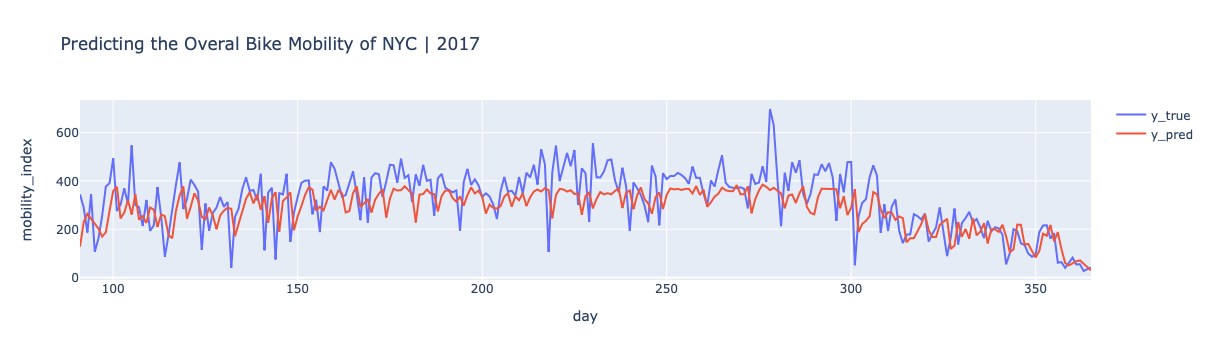

In [12]:
mask = (df['year'] == 2017)
y_pred = rfr.predict(df.loc[mask, X])
y_true = df.loc[mask, y]

fig = go.Figure()
for y_val, name in zip([y_true, y_pred], ['y_true', 'y_pred']):
    fig.add_trace(
        go.Scatter(
            x=df.loc[mask, 'day_of_year'],
            y=y_val,
            name=name
        )
    )
   
fig.update_layout(
    title='Predicting the Overal Bike Mobility of NYC | 2017',
    yaxis=dict(title='mobility_index'),
    xaxis=dict(title='day')
)
fig.show()

### Scenario Analysis

In [ ]:
# Augment 2017 
df_scenario = df.loc[df['year']==2017, :]


df_scenario.loc[:, 'avg_tmax'] = df_scenario.loc[:, 'avg_tmax'] * 3.0
df_scenario.loc[:, 'avg_tmin'] = df_scenario.loc[:, 'avg_tmax'] * 0.5
df_scenario.loc[:, 'avg_wind'] = df_scenario.loc[:, 'avg_wind'] * 3.0


y_pred_scenario = rfr.predict(df_scenario[X])

In [ ]:
fig = go.Figure()
for y_val, name in zip([y_true, y_pred, y_pred_scenario], ['y_true', 'y_pred', 'y_pred_scenario']):
    fig.add_trace(
        go.Scatter(
            x=df.loc[mask, 'day_of_year'],
            y=y_val,
            name=name
        )
    )
   
fig.update_layout(
    title='Predicting the Overal Bike Mobility of NYC | 2017',
    yaxis=dict(title='mobility_index'),
    xaxis=dict(title='day')
)
fig.show()